# Evaluation and results analysis
Here we will create tools for detailed evaluation of the results:
- check how setting of IOU affect our evaluation metrics (precision, recall, F)
- check how evaluation metrics change depending on z-slices

### Contents:
1. <a href=#1>Loading and setting up data paths</a>
2. <a href=#2>Analyse effect of IOU on results</a>
3. <a href=#3>Analyse effect of Z-depth on results</a>

In [1]:
from notebook_utils import *

import imageio
import skimage.segmentation
import skimage.filters

import scipy.stats

import random

import os
import shutil
import glob

%matplotlib inline

# Loading and setting up data paths <a name='1' />

In [2]:
# dir root is a path to folder where evaluation is output
# (there are folders like data_input, data_annotations and Model3_CC_labels (with Output subfolder))
dir_root = r'D:\Fafa\MIT\CellDx\eval_analysis_2_dil\results'

# thats a path to summary.txt for annotation data that can be found on private/annotations
annotation_summary_path = r'D:\Fafa\MIT\CellDx\eval_analysis_2_dil\summary.txt'

def solution_output_dir(solution_name, add_02_suffix):
    suffix = "_0.2" if add_02_suffix else ""
    evaluation_dir = os.path.join(dir_root, solution_name + '_labels' + suffix, 'Output')
    return evaluation_dir

def get_seg_plot_path(solution_name, add_02_suffix):
    evaluation_dir = solution_output_dir(solution_name, add_02_suffix)
    return glob.glob(os.path.join(evaluation_dir, '*.segplot.txt'))[0]

def get_details_path(solution_name, add_02_suffix = True):
    evaluation_dir = solution_output_dir(solution_name, add_02_suffix)
    details_path = glob.glob(os.path.join(evaluation_dir, '*.segdetails.txt'))[0]
    return details_path

def get_mapping_path():
    return os.path.join(dir_root, 'data_input','mapping.txt')

# Analyse effect of IOU on results <a name='2' />

In [3]:
import sklearn.metrics

In [8]:
import pandas

detailsCC = pandas.read_csv(get_details_path('model_1_DCAN_2', False))
detailsCC[:15:3]

,Frame,Result,GT_id,GT_pos_x,GT_pos_y,Algo_id,Algo_pos_x,Algo_pos_y,IOU
0,1,CORRECT,1.0,188.448598,37.580774,3.0,188.028112,38.281124,0.664887
3,1,CORRECT,5.0,186.800995,194.855721,13.0,185.705882,195.544118,0.668317
6,1,CORRECT,9.0,130.791096,23.398973,2.0,130.844262,26.356557,0.709729
9,1,CORRECT,14.0,88.694444,111.694444,7.0,89.174917,112.811881,0.801724
12,1,CORRECT,26.0,109.080645,159.612903,9.0,110.000000,159.000000,0.403226


In [9]:
detailsIMARIS = pandas.read_csv(get_details_path('DCAN_2_IMARIS_0.2', False))
detailsIMARIS[:15:3]

,Frame,Result,GT_id,GT_pos_x,GT_pos_y,Algo_id,Algo_pos_x,Algo_pos_y,IOU
0,1,CORRECT,1.0,188.448598,37.580774,3.0,188.832822,38.104294,0.868000
3,1,CORRECT,4.0,187.781708,133.621225,10.0,187.010846,115.991323,0.283677
6,1,CORRECT,8.0,143.521595,4.485050,1.0,143.239726,4.458904,0.882540
9,1,CORRECT,12.0,80.140969,139.488987,11.0,75.074313,137.508885,0.330189
12,1,CORRECT,19.0,53.433180,190.476959,13.0,55.424419,192.075581,0.752252


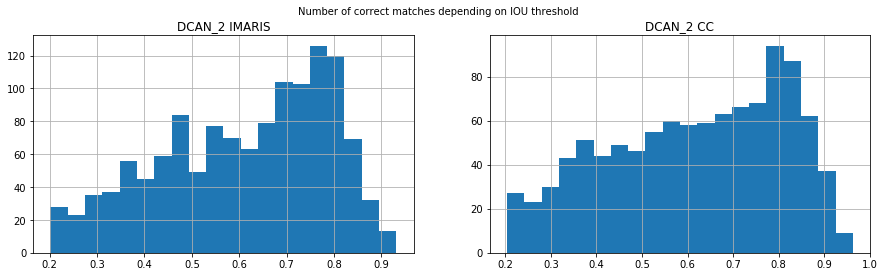

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15, 4))
fig.suptitle('Number of correct matches depending on IOU threshold',fontsize=10)
ax[0].set_title("DCAN_2 IMARIS")
detailsIMARIS['IOU'].hist(bins=20,ax=ax[0])
ax[1].set_title("DCAN_2 CC")
detailsCC['IOU'].hist(bins=20,ax=ax[1])
plt.show()

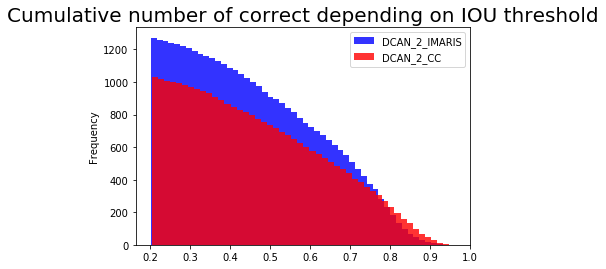

In [11]:
ax = detailsIMARIS['IOU'].plot(kind='hist',label='DCAN_2_IMARIS', bins=50,  cumulative=-1, fc=(0, 0, 1, 0.8), legend=True)
detailsCC['IOU'].plot(kind='hist',label='DCAN_2_CC', bins=50, cumulative=-1, fc=(1, 0, 0, 0.8), legend=True)
ax.set_title("Cumulative number of correct depending on IOU threshold", fontsize = 20);

### Now for model_3

In [13]:
detailsCC = pandas.read_csv(get_details_path('model_3', False))
detailsIMARIS = pandas.read_csv(get_details_path('model_3_IMARIS_0.2', False))

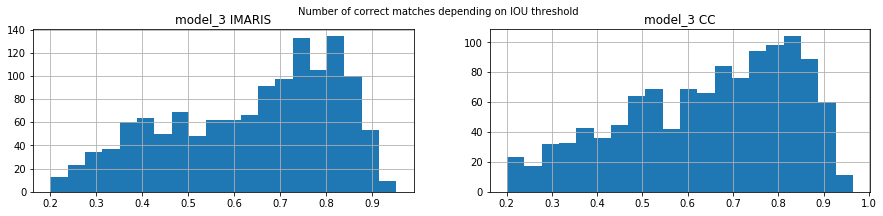

In [14]:
fig, ax = plt.subplots(1,2, figsize=(15, 3))
fig.suptitle('Number of correct matches depending on IOU threshold',fontsize=10)
ax[0].set_title("model_3 IMARIS")
detailsIMARIS['IOU'].hist(bins=20,ax=ax[0])
ax[1].set_title("model_3 CC")
detailsCC['IOU'].hist(bins=20,ax=ax[1])
plt.show()

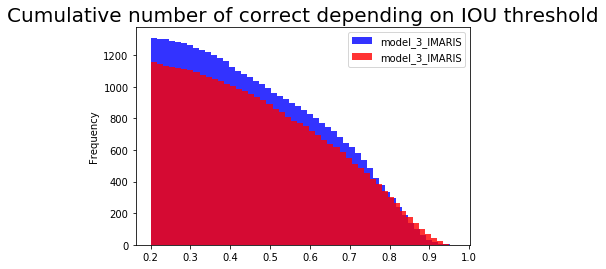

In [15]:
ax = detailsIMARIS['IOU'].plot(kind='hist',label='model_3_IMARIS', bins=50, cumulative=-1, fc=(0, 0, 1, 0.8), legend=True)
ax.set_title("Cumulative number of correct depending on IOU threshold", fontsize = 20)
detailsCC['IOU'].plot(kind='hist',label='model_3_IMARIS',bins=50, cumulative=-1, fc=(1, 0, 0, 0.8), legend=True)

# Analyse effect of Z-depth on results <a name='3' />

In [16]:
import re

def load_parse_segplot(path):
    with open(path) as f:
        data = f.read()
    dataseries = data.split('\n\n')
    precision, recall, f = dataseries[1:]
    def parse_dataseries(data):
        return [p.split(' ') for p in data.strip().split('\n')]
    return list(map(parse_dataseries, dataseries[1:]))

def load_parse_mapping(path):
    with open(path) as f:
        lines = f.readlines()
    pairs = [d[1:-3].split(', ') for d in lines]
    pairs_with_filename = [(nr, os.path.basename(p)) for nr, p in pairs]
    pairs_with_filename_page = [(nr, tuple(p.rsplit('_',1))) for nr, p in pairs_with_filename]
    pairs_with_filename_page_droped_tif = [(nr, (fn[:-4],p)) for nr, (fn, p) in pairs_with_filename_page]
    return dict(pairs_with_filename_page_droped_tif)

def load_parse_annotation_summary(path):
    with open(path) as f:
        lines = f.readlines()
    only_crops = [l.strip() for l in lines if not l.startswith("DATASET")]
    crops_info = list(zip(only_crops[::2], only_crops[1::2]))
    return dict([(l[6:-5], re.split('\[|\]', r)[1].split(', ')) for l,r in crops_info])

In [17]:
def sort_plot_by_z(seg_plot_path):
    precision, recall, f = load_parse_segplot(seg_plot_path)
    mapping = load_parse_mapping(get_mapping_path())
    summary = load_parse_annotation_summary(annotation_summary_path)
    
    def change_to_z(plot_data):
        res = []
        for nr, val in plot_data:
            filename, page = mapping[nr]
            z = summary[filename][int(page)-1]
            res.append((int(z), float(val)))
        return sorted(res)
    
    precision = change_to_z(precision)
    recall = change_to_z(recall)
    f = change_to_z(f)
    
    zs = list(zip(*precision))[0]
    precision_val = list(zip(*precision))[1]
    recall_val = list(zip(*recall))[1]
    f_val = list(zip(*f))[1]

    return zs, precision_val, recall_val, f_val

def plot_sorted_by_z(seg_plot_path):
    z, p, r, f = sort_plot_by_z(seg_plot_path)
    df = pandas.DataFrame({'precision' : p, 'recall' : r, 'F' : f}, index=z)
    ax = df.plot(figsize=(15,5), grid=True,style='o')
    ax.set_xlabel("Z-DEPTH")

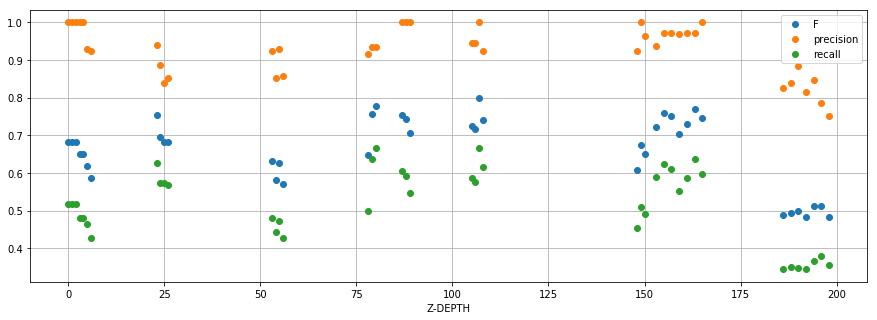

In [18]:
plot_sorted_by_z(get_seg_plot_path('model_1_DCAN_2', False))

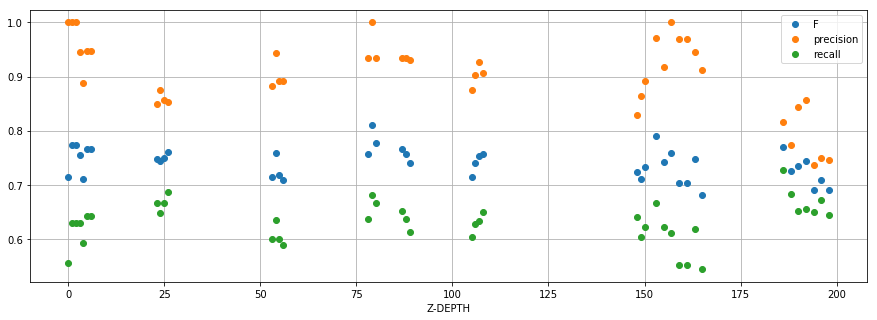

In [20]:
plot_sorted_by_z(get_seg_plot_path('DCAN_2_IMARIS_0.2', False))

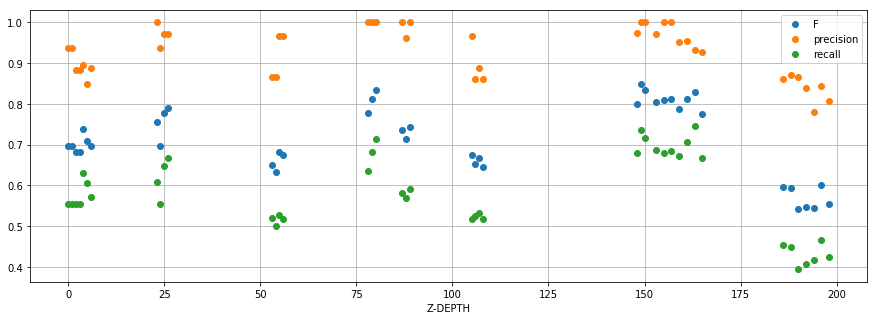

In [21]:
plot_sorted_by_z(get_seg_plot_path('model_3', False))

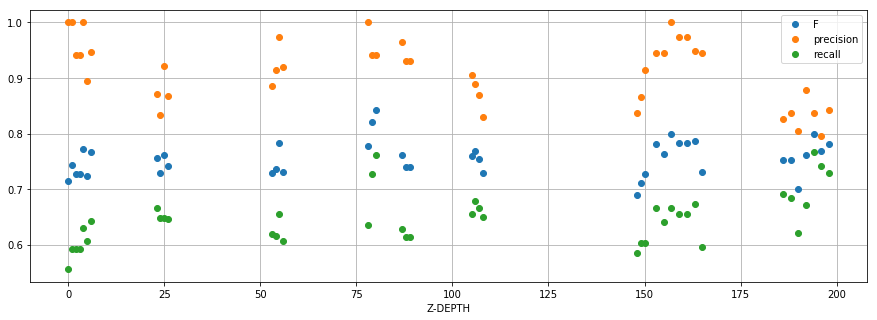

In [22]:
plot_sorted_by_z(get_seg_plot_path('model_3_IMARIS_0.2', False))